### Ay 119 Deep Learning Exercises

Matthew Graham, 2025

In [2]:
!pip install pandas matplotlib h5py pyarrow torch
!pip install "numpy<2"

zsh:1: /Users/andrewzabelo/Desktop/ay119_2025_deeplearning_completed/.conda/bin/pip: bad interpreter: /Users/andrewzabelo/Desktop/ay119_2025_deeplearning/.conda/bin/python: no such file or directory
  Obtaining dependency information for pyarrow from https://files.pythonhosted.org/packages/5b/23/77094eb8ee0dbe88441689cb6afc40ac312a1e15d3a7acc0586999518222/pyarrow-20.0.0-cp310-cp310-macosx_12_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 11.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 25.1
[notice] To update, run: /opt/homebrew/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip
zsh:1: /Users/andrewzabelo/Desktop/ay119_2025_deeplearning_completed/.conda/bin/pip: bad interpreter: /Users/andrewzabelo/Desktop/ay119_2025_deeplearning/.conda/bin/python: no such file or directory

[notice] A new release of pip is available: 23.2.1 -> 25.1
[notice] To update, run: /opt/homebrew/opt/python@3.10/bin/python3.10 -m pip 

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import h5py
import gzip
import io
import torch

The data for these exercises consist of 10,000 thumbnails (64 x 64 x 3) from SDSS of four different types of galaxy: smooth round, smooth cigar, edge on disk, and unbarred spiral. They have already been divided up into a training data set of 8,000 and a test data set of 2,000. They can be downloaded from:

  * http://astro.caltech.edu/~mjg/train_dataset.hdf5.gz
  * http://astro.caltech.edu/~mjg/test_dataset.hdf5.gz
  * http://astro.caltech.edu/~mjg/galaxy_mnist_train_catalog.parquet
  * http://astro.caltech.edu/~mjg/galaxy_mnist_test_catalog.parquet

We define our four classes:

In [4]:
classes = ['smooth_round', 'smooth_cigar', 'edge_on_disk', 'unbarred_spiral']

The catalogs are in Parquet format which it is straightforward enough to deal with via Pandas:

In [5]:
# Path to your parquet catalog file
catalog = pd.read_parquet("galaxy_mnist_train_catalog.parquet")

The labels/targets are given by:

In [6]:
y = catalog['label'].to_numpy(dtype = np.uint8)

In [7]:
y

array([1, 1, 3, ..., 3, 2, 0], dtype=uint8)

and the images are can be read into a Numpy array via:

In [8]:
import gzip
import shutil
import os

def compress_hdf5_to_gz(input_file_path):
    if not input_file_path.endswith(".hdf5"):
        raise ValueError("Input file must be a .hdf5 file")

    output_file_path = input_file_path + ".gz"

    with open(input_file_path, 'rb') as f_in:
        with gzip.open(output_file_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    print(f"Compressed file created at: {output_file_path}")


input_path = "train_dataset.hdf5"  
compress_hdf5_to_gz(input_path)
input_path = "test_dataset.hdf5"  
compress_hdf5_to_gz(input_path)


Compressed file created at: train_dataset.hdf5.gz
Compressed file created at: test_dataset.hdf5.gz


In [9]:
# Path to your gzipped HDF5 file
filename = 'train_dataset.hdf5.gz'

# Open and read the gzip file into memory
with gzip.open(filename, 'rb') as f:
    decompressed_data = f.read()

# Use BytesIO to treat it as a file object for h5py
with h5py.File(io.BytesIO(decompressed_data), 'r') as h5f:
    a_group_key = list(h5f.keys())[0]
    X = h5f[a_group_key][()]  

Check data shape:

In [10]:
def process_data(X):
    X = X.astype(float)
    torch_X = torch.tensor(X)
    torch_X = torch_X.permute(0, 3, 1, 2)
    torch_X = torch_X.float() / 255.0  # Now values are in [0, 1]

    # Compute mean and std per channel
    mean = torch_X.mean(dim=(0, 2, 3))  # mean for each channel
    std = torch_X.std(dim=(0, 2, 3))    # std for each channel

    print("Mean:", mean)
    print("Std:", std)

    # Normalize: (x - mean) / std
    normalized_X = (torch_X - mean[None, :, None, None]) / std[None, :, None, None]
    normalized_X[1]

    return torch_X, normalized_X

In [11]:
torch_X, normalized_X = process_data(X)

Mean: tensor([0.1160, 0.1067, 0.1064])
Std: tensor([0.1062, 0.1011, 0.0970])


Note that if you are working with PyTorch, you will need to transpose this to (8000, 3, 64, 64). In either case, do not forget to normalize the values (hint: the maximum value in any pixel is 255).

Here's a plot of the first 5 images in each class just to make sure everything looks OK:

In [12]:
def plot_image(image_tensor, ax=None):
    if ax is None:
        ax = plt.gca()

    image_tensor = np.array(image_tensor)
    # convert to numpy array
    image = np.array(image_tensor)
    # move the RGB axis to the end
    image = np.moveaxis(image, 0, -1)
    # plot on the given axis object
    ax.imshow(image)

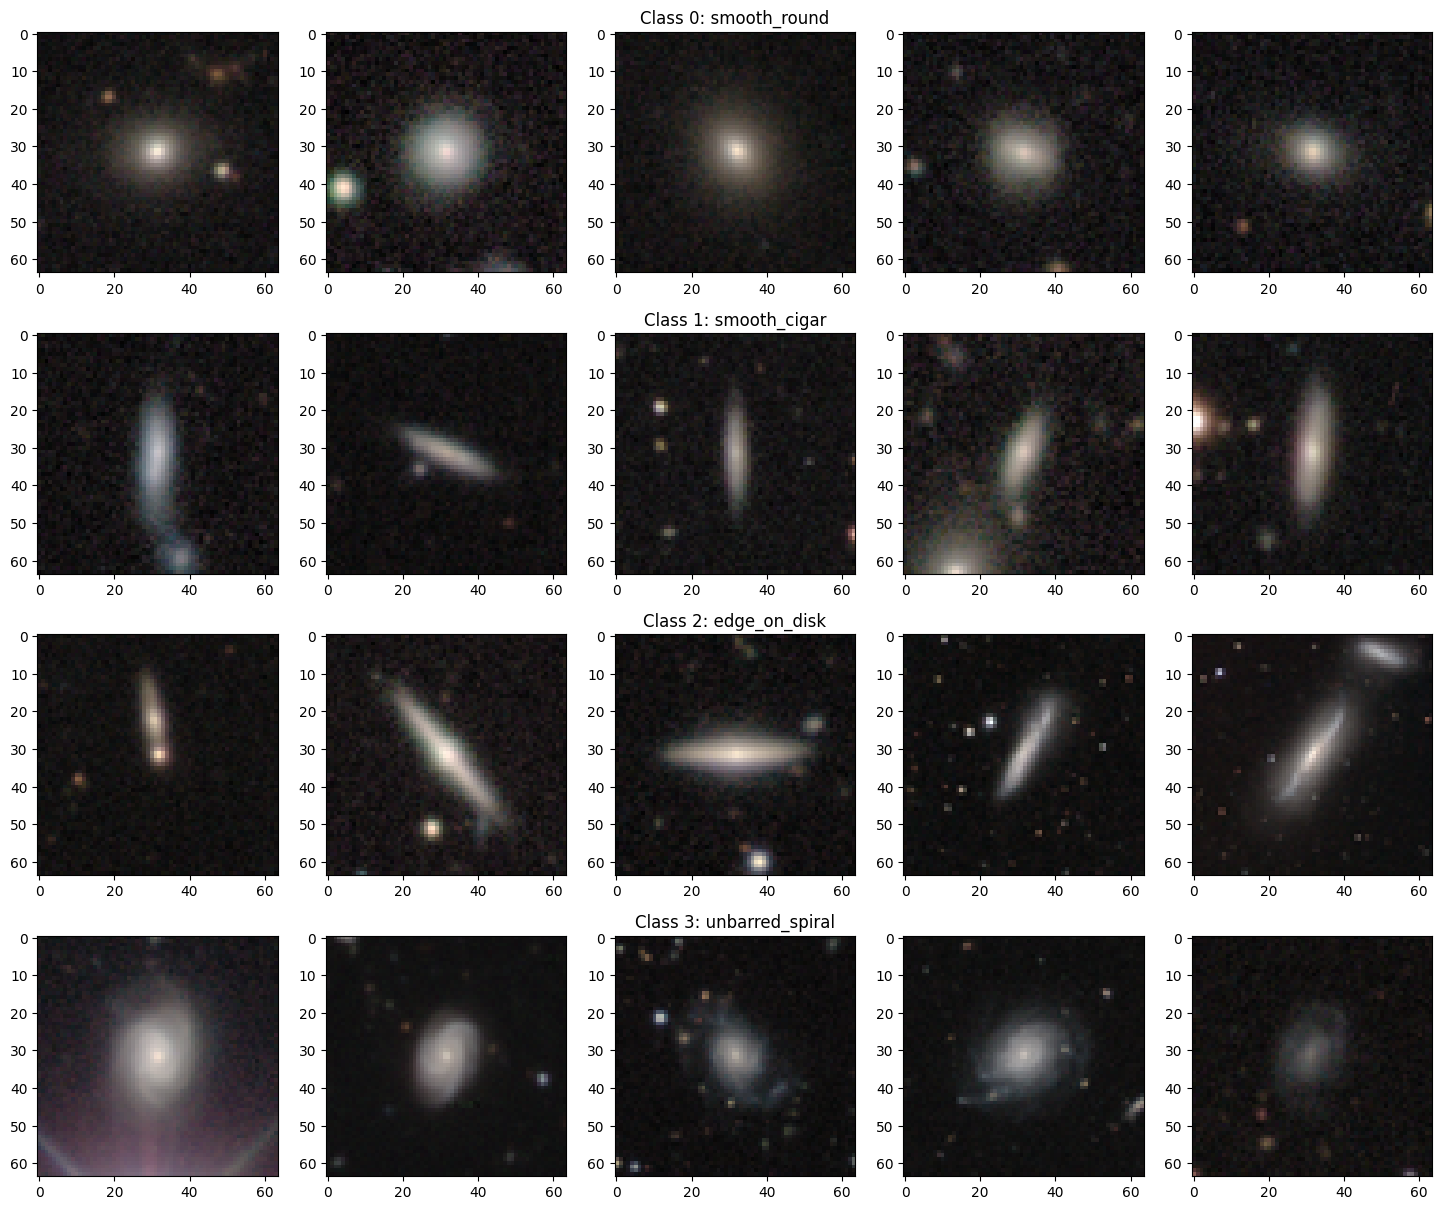

In [13]:
fig = plt.figure(figsize=(18, 15))
# use gridsped for creating subplots
gs = GridSpec(4, 5)

for i in range(4):
    # get images for the class
    idx = y == i
    idx = torch.tensor(idx.astype(float)).bool()
    images_idx = torch_X[idx]
    # print(images_idx.shape)
    # break
    for j in range(5):
        # plot the first 5 images for each class
        ax = fig.add_subplot(gs[i, j])
        plot_image(images_idx[j], ax=ax)
        # place a title for each row
        if j == 2:
            ax.set_title(f'Class {i}: {classes[i]}')

Remember to also load the test data catalog and images:

In [14]:
# Path to your gzipped HDF5 file
filename = 'test_dataset.hdf5.gz'

# Open and read the gzip file into memory
with gzip.open(filename, 'rb') as f:
    decompressed_data = f.read()

# Use BytesIO to treat it as a file object for h5py
with h5py.File(io.BytesIO(decompressed_data), 'r') as h5f:
    a_group_key = list(h5f.keys())[0]
    X_test = h5f[a_group_key][()]  

torch_X_test, normalized_X_test = process_data(X_test)
catalog_test = pd.read_parquet("galaxy_mnist_test_catalog.parquet")
y_test = catalog_test['label'].to_numpy(dtype = np.uint8)
y_test = torch.tensor(y_test)

display(torch_X_test.shape)
display(y_test.shape)

Mean: tensor([0.1166, 0.1072, 0.1068])
Std: tensor([0.1074, 0.1021, 0.0977])


torch.Size([2000, 3, 64, 64])

torch.Size([2000])

### Exercise 1: 

Write and train a fully connected network (MLP) with 3 hidden layers, each with 512 nodes.

Remember to use some fraction of the training data set for validation - the test data set is only to be used after training to assess the accuracy of the network. If you are using PyTorch for implementation then you probably have to load the data into PyTorch tensors with the correct data type. 

Use sparse categorical cross entropy for loss function, a learning rate of 0.0015, and train for 50 epochs:

In [15]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # flatten
        x = x.reshape(x.shape[0], -1)
        # Forward pass with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # Output layer (no activation here for regression, softmax for classification)
        return x

In [16]:
num_classes = 4
input_size = 3 * 64 * 64

model = MLP(input_size=input_size, hidden_size=512, output_size=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0015)
model

MLP(
  (fc1): Linear(in_features=12288, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=4, bias=True)
)

In [17]:
X_train = normalized_X[:6000]
X_val = normalized_X[6000:]

y = torch.tensor(y)
y_train = y[:6000]
y_val = y[6000:]

In [18]:
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()

    # mini batch
    outputs = model(X_train)

    # Calculate training loss
    train_loss = criterion(outputs, y_train)

    # Backward pass and optimization
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()  # Set the model to evaluation mode (no gradients)
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)

    # Store losses for plotting
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    # Print training and validation loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

Epoch [1/50], Train Loss: 1.3877, Val Loss: 1.4379
Epoch [2/50], Train Loss: 1.4320, Val Loss: 5.4892
Epoch [3/50], Train Loss: 5.4645, Val Loss: 3.8689
Epoch [4/50], Train Loss: 3.8592, Val Loss: 2.0002
Epoch [5/50], Train Loss: 1.9352, Val Loss: 1.6815
Epoch [6/50], Train Loss: 1.6402, Val Loss: 1.4652
Epoch [7/50], Train Loss: 1.4489, Val Loss: 1.3953
Epoch [8/50], Train Loss: 1.3881, Val Loss: 1.3486
Epoch [9/50], Train Loss: 1.3441, Val Loss: 1.3452
Epoch [10/50], Train Loss: 1.3357, Val Loss: 1.3389
Epoch [11/50], Train Loss: 1.3202, Val Loss: 1.3300
Epoch [12/50], Train Loss: 1.2994, Val Loss: 1.3089
Epoch [13/50], Train Loss: 1.2715, Val Loss: 1.2787
Epoch [14/50], Train Loss: 1.2411, Val Loss: 1.2436
Epoch [15/50], Train Loss: 1.2061, Val Loss: 1.2136
Epoch [16/50], Train Loss: 1.1713, Val Loss: 1.1629
Epoch [17/50], Train Loss: 1.1140, Val Loss: 1.1195
Epoch [18/50], Train Loss: 1.0640, Val Loss: 1.0674
Epoch [19/50], Train Loss: 1.0049, Val Loss: 1.0102
Epoch [20/50], Train 

Plot the training loss and the validation loss as a function of training epoch:

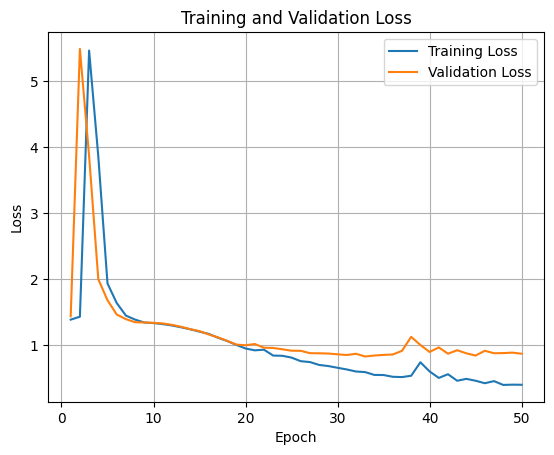

In [19]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


Evaluate the accuracy of the model on the test data set:

In [20]:
model.eval()

# Disable gradient calculation
with torch.no_grad():
    outputs = model(normalized_X_test)             # Get model predictions
    predicted = torch.argmax(outputs, dim=1)  # Predicted class indices
    correct = (predicted == y_test).sum().item()
    total = y_test.size(0)
    accuracy = correct / total * 100

print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 67.35%


Produce a confusion matrix for the model.

In [21]:
pip install seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


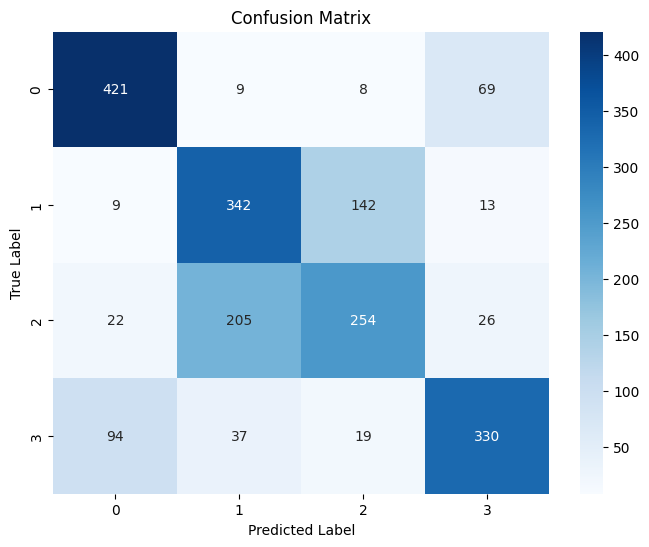

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test.cpu(), predicted.cpu())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Exercise 2:

Let's try a convolutional neural network instead - write a 3 layer CNN with 32 features in the first layer, 64 in the second and 128 in the final layer and then a fully connected layer for classification:

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout
        self.dropout = nn.Dropout(p=0.2)

        # Fully connected layer
        self.fc = nn.Linear(128 * 8 * 8, num_classes)  # 64x64 input → 8x8 after 3 poolings

    def forward(self, x):
        # Conv + ReLU + Pooling + Dropout
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)

        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)

        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layer
        x = self.fc(x)
        return x


Run it for 50 epochs and assess the accuracy on the test data set and produce a confusion matrix.

In [24]:
num_classes = 4

model = CNN(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0015)
model

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=8192, out_features=4, bias=True)
)

Note: this tests whether you read all the instructions before starting. You probably want to use Dropout layers in your neural networks with a dropout rate of 0.2.

In [25]:
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()

    # mini batch
    outputs = model(X_train)

    # Calculate training loss
    train_loss = criterion(outputs, y_train)

    # Backward pass and optimization
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()  # Set the model to evaluation mode (no gradients)
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)

    # Store losses for plotting
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    # Print training and validation loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

Epoch [1/50], Train Loss: 1.3909, Val Loss: 1.5859
Epoch [2/50], Train Loss: 1.7280, Val Loss: 1.3653
Epoch [3/50], Train Loss: 1.3649, Val Loss: 1.3670
Epoch [4/50], Train Loss: 1.3877, Val Loss: 1.3717
Epoch [5/50], Train Loss: 1.3825, Val Loss: 1.3749
Epoch [6/50], Train Loss: 1.3775, Val Loss: 1.3764
Epoch [7/50], Train Loss: 1.3756, Val Loss: 1.3759
Epoch [8/50], Train Loss: 1.3738, Val Loss: 1.3733
Epoch [9/50], Train Loss: 1.3704, Val Loss: 1.3682
Epoch [10/50], Train Loss: 1.3652, Val Loss: 1.3606
Epoch [11/50], Train Loss: 1.3575, Val Loss: 1.3503
Epoch [12/50], Train Loss: 1.3474, Val Loss: 1.3375
Epoch [13/50], Train Loss: 1.3356, Val Loss: 1.3239
Epoch [14/50], Train Loss: 1.3183, Val Loss: 1.3093
Epoch [15/50], Train Loss: 1.2968, Val Loss: 1.2898
Epoch [16/50], Train Loss: 1.2714, Val Loss: 1.2610
Epoch [17/50], Train Loss: 1.2411, Val Loss: 1.2253
Epoch [18/50], Train Loss: 1.2089, Val Loss: 1.1977
Epoch [19/50], Train Loss: 1.1832, Val Loss: 1.1650
Epoch [20/50], Train 

Test Accuracy: 65.50%


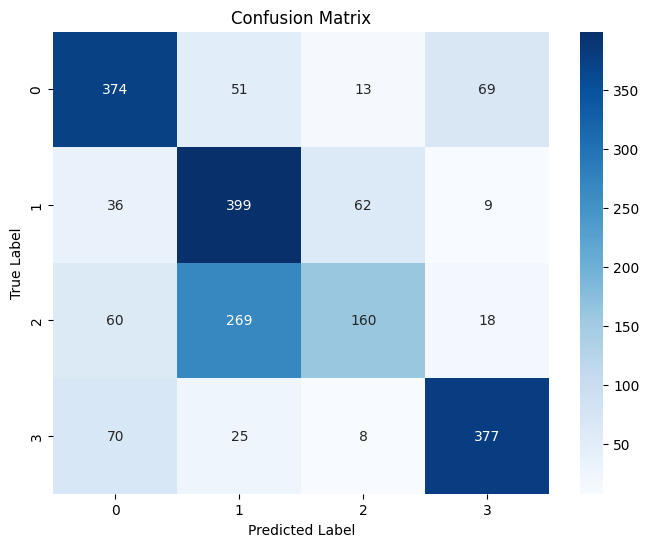

In [28]:
model.eval()

# Disable gradient calculation
with torch.no_grad():
    outputs = model(normalized_X_test)             # Get model predictions
    predicted = torch.argmax(outputs, dim=1)  # Predicted class indices
    correct = (predicted == y_test).sum().item()
    total = y_test.size(0)
    accuracy = correct / total * 100

print(f'Test Accuracy: {accuracy:.2f}%')

cm = confusion_matrix(y_test.cpu(), predicted.cpu())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [29]:
# Not sure why the CNN performed worse than the MLP. In theory its inductive bias should have made it perform better.

In [27]:
# minibatch or SGD would have likely been better

### Optional:

See if you can improve on either the MLP or CNN accuracy with more layers, nodes, training epochs, learning rates.

Investigate whether there are any common properties to the galaxies that are misclassified.
